In [40]:
import os
import sys
import random
import sklearn
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf # NOTE: this has to use Tensorflow version 1.x
import numpy as np
import cv2
import scipy as sp
import glob
import copy
import dlib
import math
import time
from skimage import io
from pathlib import Path
%matplotlib inline

In [51]:
dataset_path = "./deepfashion/"
image_paths = glob.glob("deepfashion/img/**/*.jpg")

In [49]:
def load_images(image_paths, offset=100):
    images = []
    for image_path in image_paths[:offset]:
        image = np.asarray(Image.open(image_path))
        images.append(image)
    return(np.array(images))

offset = 100
images = load_images(image_paths, offset=offset)

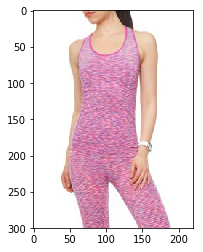

In [50]:
plt.imshow(images[random.randint(0,offset-1)])

In [63]:
# load annots and eval
# Total 50: "1" represents upper-body clothes, "2" represents lower-body clothes, "3" represents full-body clothes
cat_cloth_file = os.path.join(dataset_path, 'Anno/list_category_cloth.txt')
cat_img_file = os.path.join(dataset_path, 'Anno/list_category_img.txt')
attr_cloth_file = os.path.join(dataset_path, 'Anno/list_attr_cloth.txt')
attr_img_file = os.path.join(dataset_path, 'Anno/list_attr_img.txt')
eval_file = os.path.join(dataset_path, 'Eval/list_eval_partition.txt')

In [67]:
# read in dataframes
import pandas as pd
cat_cloth_df = pd.read_csv(cat_cloth_file, sep='\s+', skiprows=1)
cat_img_df = pd.read_csv(cat_img_file, sep='\s+', skiprows=1)
attr_cloth_df = pd.read_csv(attr_cloth_file, sep='\t', skiprows=1)
attr_img_df = pd.read_csv(attr_img_file, sep='\s+', skiprows=1)
eval_df = pd.read_csv(eval_file, sep='\s+', skiprows=1)


In [86]:
cat_cloth_df.head(50)

,category_name,category_type
0,Anorak,1
1,Blazer,1
2,Blouse,1
3,Bomber,1
4,Button-Down,1
5,Cardigan,1
6,Flannel,1
7,Halter,1
8,Henley,1
9,Hoodie,1


In [69]:
cat_cloth_df.count()

category_name    50
category_type    50
dtype: int64

In [70]:
cat_img_df.head()

,image_name,category_label
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3


In [87]:
attr_cloth_df.head(10)

,attribute_name attribute_type
0,a-line 3
1,abstract 1
2,abstract chevron 1
3,abstract chevron print 1
4,abstract diamond 1
5,abstract floral 1
6,abstract floral print 1
7,abstract geo 1
8,abstract geo print 1
9,abstract paisley 1


In [73]:
attr_img_df.head()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,image_name,attribute_labels
img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1

In [132]:
attr_img_df.iloc[0:5]

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,image_name,attribute_labels
img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1

In [149]:
attr_img_dict["img/Sheer_Pleated-Front_Blouse/img_00000005.jpg"]

[]

In [57]:
eval_df.head()

,image_name,evaluation_status
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test


In [59]:
# Merge dfs
cat_cloth_df["category_label"] = cat_cloth_df.index + 1
cat_df = cat_img_df.merge(cat_cloth_df, how='left', on='category_label')\

In [60]:
cat_df.head()

,image_name,category_label,category_name,category_type
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3,Blouse,1
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3,Blouse,1
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3,Blouse,1
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3,Blouse,1
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3,Blouse,1


In [94]:
import numpy as np, pandas as pd
import cv2
from tqdm import tqdm_notebook, tqdm # Iteration visualization
tqdm.pandas(desc="Loading") # to do progress_apply for pandas

In [96]:
def extr_data_txt(path):
    """
    Load data from text file.
    """
    with open(path, "r") as f:
        data = []
        for itr, line in tqdm_notebook(enumerate(f)):
            # Because we got annotation in the first two lines
            if itr >= 2:
                data.append(line.split())
    return data

In [98]:
train_test_valid_anot = pd.DataFrame(extr_data_txt('%s/Eval/list_eval_partition.txt' % dataset_path), 
                                     columns=['Path', 'type'])

In [99]:
train_test_valid_anot.head()

,Path,type
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test


In [100]:
train_test_valid_anot.to_csv('%s/Anno/train_test_valid_anot.csv' % dataset_path, index=False)

In [103]:
categories_img = pd.DataFrame(extr_data_txt('%s/Anno/list_category_img.txt' % dataset_path), 
                          columns=['Path', 'cat'])
categories_img['cat'] = categories_img['cat'].apply(lambda x: int(x)-1) # Categories starts with 1, fixing it.
categories_img.to_csv('%s/Anno/categories_img.csv' % dataset_path, index=False)

In [104]:
categories_img.head()

,Path,cat
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,2
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,2
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,2
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,2
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,2


In [118]:
import shutil
import os
import re
import cv2
# will use them for creating custom directory iterator
import numpy as np
from six.moves import range
# regular expression for splitting by whitespace
splitter = re.compile("\s+")
base_path = os.path.join(dataset_path, "img2")

# this method goes over list_eval_partition.txt and splits dataset in appropriate folders in the following form:
# train -> <category> -> attr -> images
# test -> <category> -> attr -> images
# val -> <category> -> attr -> images
def process_cat_attrs():
    # Read the relevant annotation file and preprocess it
    # Assumed that the annotation files are under '<dataset_path>/Eval' path
    with open('./%s/Eval/list_eval_partition.txt' % dataset_path, 'r') as eval_partition_file:
        list_eval_partition = [line.rstrip('\n') for line in eval_partition_file][2:]
        list_eval_partition = [splitter.split(line) for line in list_eval_partition]
        list_all = [(v[0][4:], v[0].split('/')[1].split('_')[-1], v[1]) for v in list_eval_partition]
    
    filecounter=len(list_all)
    # Put each image into the relevant folder in train/test/validation folder
    for element in tqdm(list_all, total=filecounter, unit="files"):
        if not os.path.exists(os.path.join(base_path, element[2])):
            os.mkdir(os.path.join(base_path, element[2]))
        if not os.path.exists(os.path.join(os.path.join(base_path, element[2]), element[1])):
            os.mkdir(os.path.join(os.path.join(base_path, element[2]), element[1]))
        if not os.path.exists(os.path.join(os.path.join(os.path.join(os.path.join(base_path, element[2]), element[1])),
                              element[0].split('/')[0])):
            os.mkdir(os.path.join(os.path.join(os.path.join(os.path.join(base_path, element[2]), element[1])),
                     element[0].split('/')[0]))
        if not os.path.exists(os.path.join(base_path, element[0])):
            print("Missing file =%s" % os.path.join(base_path, element[0]))
            continue
        shutil.move(os.path.join(base_path, element[0]),
                    os.path.join(os.path.join(os.path.join(base_path, element[2]), element[1]), element[0]))        

In [ ]:
process_cat_attrs()

In [164]:
import shutil
import os
import re
import cv2
# will use them for creating custom directory iterator
import numpy as np
from six.moves import range
# regular expression for splitting by whitespace
splitter = re.compile("\s+")

base_path = os.path.join(dataset_path, "img")

# this method goes over list_eval_partition.txt and splits dataset in appropriate folders in the following form:
# train -> <category> -> images
# test -> <category> -> images
# val -> <category> -> images
def process_categories():
    # Read the relevant annotation file and preprocess it
    # Assumed that the annotation files are under '<dataset_path>/Eval' path
    with open('./%s/Eval/list_eval_partition.txt' % dataset_path, 'r') as eval_partition_file:
        list_eval_partition = [line.rstrip('\n') for line in eval_partition_file][2:]
        list_eval_partition = [splitter.split(line) for line in list_eval_partition]
        list_all = [(v[0][4:], v[0].split('/')[1].split('_')[-1], v[1]) for v in list_eval_partition]
    
    filecounter=len(list_all)
    # Put each image into the relevant folder in train/test/validation folder
    for element in tqdm(list_all, total=filecounter, unit="files"):
        # create test / train / validate
        if not os.path.exists(os.path.join(base_path, element[2])):
            os.mkdir(os.path.join(base_path, element[2]))
        # create test/<categories> / train/<categories> / validate/<categories>
        if not os.path.exists(os.path.join(os.path.join(base_path, element[2]), element[1])):
            os.mkdir(os.path.join(os.path.join(base_path, element[2]), element[1]))
        modified_fname = "%s_%s" % (element[0].split('/')[0], element[0].split('/')[1])
        if not os.path.exists(os.path.join(base_path, element[0])):
            print("Missing file or already processed =%s" % os.path.join(base_path, element[0]))
            continue        
        shutil.move(os.path.join(base_path, element[0]),
                    os.path.join(os.path.join(os.path.join(base_path, element[2]), element[1]), modified_fname))

In [ ]:
process_categories()

In [125]:
train_dataset_path=os.path.join(dataset_path, "dataset", "train")
test_dataset_path=os.path.join(dataset_path, "dataset", "test")
val_dataset_path=os.path.join(dataset_path, "dataset", "val")

### Training with pretrained model (VGG16)

In [2]:
from keras.applications import VGG16
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers

# create base vgg16 with pretrained weights from imagenet
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [3]:
conv_base.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [90]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [92]:
# freeze wts of vgg16
conv_base.trainable = False

In [168]:
dataset_path

'./deepfashion/'

In [169]:
train_dataset_path=os.path.join(dataset_path, "dataset", "train")
test_dataset_path=os.path.join(dataset_path, "dataset", "test")
val_dataset_path=os.path.join(dataset_path, "dataset", "val")

In [170]:
train_dataset_path

'./deepfashion/dataset/train'

In [171]:
!ls './deepfashion/dataset/train'

Anorak      Chinos      Halter      Joggers     Poncho      Sweatshorts
Blazer      Coat        Henley      Jumpsuit    Robe        Tank
Blouse      Coverup     Hoodie      Kaftan      Romper      Tee
Bomber      Culottes    Jacket      Kimono      Sarong      Top
Button-Down Cutoffs     Jeans       Leggings    Shorts      Trunks
Caftan      Dress       Jeggings    Onesie      Skirt       Turtleneck
Capris      Flannel     Jersey      Parka       Sweater
Cardigan    Gauchos     Jodhpurs    Peacoat     Sweatpants


In [172]:
ls './deepfashion/dataset/test'

Anorak/      Chinos/      Halter/      Joggers/     Poncho/      Sweatshorts/
Blazer/      Coat/        Henley/      Jumpsuit/    Robe/        Tank/
Blouse/      Coverup/     Hoodie/      Kaftan/      Romper/      Tee/
Bomber/      Culottes/    Jacket/      Kimono/      Sarong/      Top/
Button-Down/ Cutoffs/     Jeans/       Leggings/    Shorts/      Trunks/
Caftan/      Dress/       Jeggings/    Onesie/      Skirt/       Turtleneck/
Capris/      Flannel/     Jersey/      Parka/       Sweater/
Cardigan/    Gauchos/     Jodhpurs/    Peacoat/     Sweatpants/


In [173]:
ls './deepfashion/dataset/val'

Anorak/      Chinos/      Halter/      Joggers/     Poncho/      Sweatshorts/
Blazer/      Coat/        Henley/      Jumpsuit/    Robe/        Tank/
Blouse/      Coverup/     Hoodie/      Kaftan/      Romper/      Tee/
Bomber/      Culottes/    Jacket/      Kimono/      Sarong/      Top/
Button-Down/ Cutoffs/     Jeans/       Leggings/    Shorts/      Trunks/
Caftan/      Dress/       Jeggings/    Onesie/      Skirt/       Turtleneck/
Capris/      Flannel/     Jersey/      Parka/       Sweater/
Cardigan/    Gauchos/     Jodhpurs/    Peacoat/     Sweatpants/


In [182]:
# num_classes

46

In [4]:
# approach 2 - THIS IS THE CORRECT ONE
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers

datagen = ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 100
NUM_CLASSES = 46
TRAIN_DATA_SIZE = 20000
TEST_DATA_SIZE = 10000
VAL_DATA_SIZE = 10000
# for vgg16
img_h = 150
img_w = 150

dataset_path = "./deepfashion/"
train_dataset_path=os.path.join(dataset_path, "dataset", "train")
test_dataset_path=os.path.join(dataset_path, "dataset", "test")
val_dataset_path=os.path.join(dataset_path, "dataset", "val")

def extract_features(directory, sample_count, n_H=img_h, n_W=img_w, batch_size=BATCH_SIZE, num_category=NUM_CLASSES):
    # since final layer of vgg16 pretrained has 4, 4, 512 dims
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, num_category))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(n_H, n_W),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        print("batch=%s, features dim=%s, labels_dim=%s" % (i, features.shape, labels.shape))        
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dataset_path, 20000)
validation_features, validation_labels = extract_features(val_dataset_path, 10000)
test_features, test_labels = extract_features(test_dataset_path, 10000)

Found 209215 images belonging to 46 classes.
batch=1, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=2, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=3, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=4, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=5, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=6, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=7, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=8, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=9, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=10, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=11, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=12, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=13, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=14, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=15, features dim=(20000, 4, 4, 512

batch=125, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=126, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=127, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=128, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=129, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=130, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=131, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=132, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=133, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=134, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=135, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=136, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=137, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=138, features dim=(20000, 4, 4, 512), labels_dim=(20000, 46)
batch=139, features dim=(20000, 4, 4, 512), labels_dim=(20000,

batch=48, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=49, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=50, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=51, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=52, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=53, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=54, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=55, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=56, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=57, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=58, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=59, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=60, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=61, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=62, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=63, 

batch=72, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=73, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=74, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=75, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=76, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=77, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=78, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=79, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=80, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=81, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=82, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=83, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=84, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=85, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=86, features dim=(10000, 4, 4, 512), labels_dim=(10000, 46)
batch=87, 

In [5]:
train_features.shape

(20000, 4, 4, 512)

In [6]:
validation_features.shape

(10000, 4, 4, 512)

In [7]:
test_features.shape

(10000, 4, 4, 512)

In [9]:
# The extracted features are currently of shape (samples, 4, 4, 512). 
# We will feed them to a densely-connected classifier, so first we must flatten them to (samples, 8192)

TRAIN_DATA_SIZE = 20000
TEST_DATA_SIZE = 10000
VAL_DATA_SIZE = 10000


train_features = np.reshape(train_features, (TRAIN_DATA_SIZE, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (VAL_DATA_SIZE, 4 * 4 * 512))
test_features = np.reshape(test_features, (TEST_DATA_SIZE, 4 * 4 * 512))

In [13]:
# save resized features for quick future runs
np.save('vgg16_bottleneck_deepfashion_train_20k_100.npy', train_features)
np.save('vgg16_bottleneck_deepfashion_val_20k_100.npy', validation_features)
np.save('vgg16_bottleneck_deepfashion_test_20k_100.npy', test_features)
np.save('vgg16_deepfashion_train_20k_100_labels.npy', train_labels)
np.save('vgg16_deepfashion_val_20k_100_labels.npy', validation_labels)
np.save('vgg16_deepfashion_test_20k_100_labels.npy', test_labels)

In [34]:
from time import time
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import TensorBoard

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

tensorboard = TensorBoard(log_dir="./deepfashion/tboard-logs/{}".format(time()), 
                          write_graph=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 46)                11822     
Total params: 2,109,230
Trainable params: 2,109,230
Non-trainable params: 0
_________________________________________________________________


In [35]:
# set epochs + batch size
NUM_EPOCHS = 100
history = model.fit(train_features, train_labels,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels),
                    verbose=1, callbacks=[tensorboard])

Train on 20000 samples, validate on 10000 samples
Epoch 1/100
20000/20000 [==============================] - 11s 543us/step - loss: 2.9731 - acc: 0.2522 - val_loss: 2.5668 - val_acc: 0.3270
Epoch 2/100
20000/20000 [==============================] - 10s 486us/step - loss: 2.6359 - acc: 0.3193 - val_loss: 2.3946 - val_acc: 0.3561
Epoch 3/100
20000/20000 [==============================] - 10s 486us/step - loss: 2.4819 - acc: 0.3440 - val_loss: 2.2844 - val_acc: 0.3763
Epoch 4/100
20000/20000 [==============================] - 8s 407us/step - loss: 2.3654 - acc: 0.3698 - val_loss: 2.2068 - val_acc: 0.3946
Epoch 5/100
20000/20000 [==============================] - 7s 340us/step - loss: 2.2740 - acc: 0.3843 - val_loss: 2.1457 - val_acc: 0.4060
Epoch 6/100
20000/20000 [==============================] - 8s 380us/step - loss: 2.2038 - acc: 0.3988 - val_loss: 2.1026 - val_acc: 0.4176
Epoch 7/100
20000/20000 [==============================] - 7s 360us/step - loss: 2.1490 - acc: 0.4111 - val_loss:

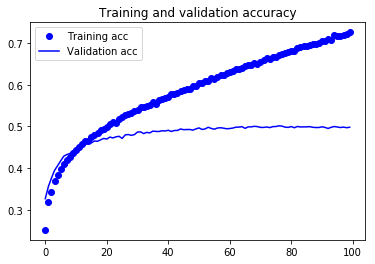

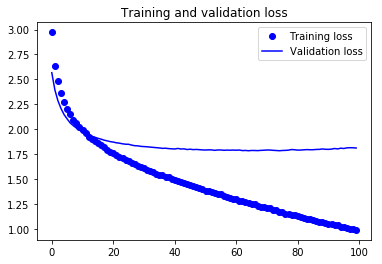

In [36]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc (RMSProp=> lr=2e-5)')
plt.plot(epochs, val_acc, 'b', label='Validation acc (RMSProp=> lr=2e-5)')
plt.title('Training and validation accuracy (RMSProp=> lr=2e-5)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss (RMSProp=> lr=2e-5)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (RMSProp=> lr=2e-5)')
plt.title('Training and validation loss (RMSProp=> lr=2e-5)')
plt.legend()

plt.show()

#### Using Adam optimizer with default learning rate

In [50]:
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

# add tensorboard callback
# tensorboard = TensorBoard(log_dir="./deepfashion/tboard-logs/{}".format(time()), 
#                           histogram_freq=1, 
#                           write_graph=True, 
#                           write_images=True)

tensorboard = TensorBoard(log_dir="./deepfashion/tboard-logs/{}".format(time()), 
                          write_graph=True)

In [51]:
# set epochs + batch size
NUM_EPOCHS = 100
adam_history = model.fit(train_features, train_labels,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels),
                    verbose=1, callbacks=[tensorboard])

Train on 20000 samples, validate on 10000 samples
Epoch 1/100
20000/20000 [==============================] - 9s 458us/step - loss: 2.6261 - acc: 0.3035 - val_loss: 2.2398 - val_acc: 0.3765
Epoch 2/100
20000/20000 [==============================] - 9s 434us/step - loss: 2.3039 - acc: 0.3561 - val_loss: 2.1132 - val_acc: 0.3959
Epoch 3/100
20000/20000 [==============================] - 9s 441us/step - loss: 2.1950 - acc: 0.3737 - val_loss: 2.0737 - val_acc: 0.4088
Epoch 4/100
20000/20000 [==============================] - 10s 487us/step - loss: 2.1221 - acc: 0.3885 - val_loss: 1.9861 - val_acc: 0.4226
Epoch 5/100
20000/20000 [==============================] - 10s 514us/step - loss: 2.0621 - acc: 0.3985 - val_loss: 1.9603 - val_acc: 0.4319
Epoch 6/100
20000/20000 [==============================] - 11s 549us/step - loss: 2.0243 - acc: 0.4080 - val_loss: 1.9542 - val_acc: 0.4375
Epoch 7/100
20000/20000 [==============================] - 9s 464us/step - loss: 1.9793 - acc: 0.4187 - val_loss:

Epoch 59/100
20000/20000 [==============================] - 9s 439us/step - loss: 1.2903 - acc: 0.5830 - val_loss: 2.2460 - val_acc: 0.4442
Epoch 60/100
20000/20000 [==============================] - 9s 448us/step - loss: 1.2979 - acc: 0.5761 - val_loss: 2.2972 - val_acc: 0.4490
Epoch 61/100
20000/20000 [==============================] - 9s 444us/step - loss: 1.2563 - acc: 0.5882 - val_loss: 2.3331 - val_acc: 0.4358
Epoch 62/100
20000/20000 [==============================] - 9s 450us/step - loss: 1.2712 - acc: 0.5854 - val_loss: 2.3276 - val_acc: 0.4411
Epoch 63/100
20000/20000 [==============================] - 9s 455us/step - loss: 1.2565 - acc: 0.5872 - val_loss: 2.3432 - val_acc: 0.4435
Epoch 64/100
20000/20000 [==============================] - 9s 444us/step - loss: 1.2538 - acc: 0.5883 - val_loss: 2.3517 - val_acc: 0.4413
Epoch 65/100
20000/20000 [==============================] - 9s 457us/step - loss: 1.2534 - acc: 0.5883 - val_loss: 2.3622 - val_acc: 0.4462
Epoch 66/100
20000/2

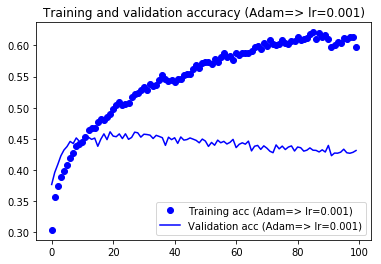

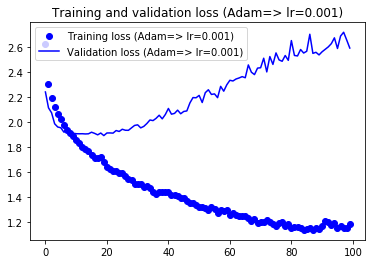

In [52]:
import matplotlib.pyplot as plt

acc = adam_history.history['acc']
val_acc = adam_history.history['val_acc']
loss = adam_history.history['loss']
val_loss = adam_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc (Adam=> lr=0.001)')
plt.plot(epochs, val_acc, 'b', label='Validation acc (Adam=> lr=0.001)')
plt.title('Training and validation accuracy (Adam=> lr=0.001)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss (Adam=> lr=0.001)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (Adam=> lr=0.001)')
plt.title('Training and validation loss (Adam=> lr=0.001)')
plt.legend()

plt.show()